In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import os
import json
import sys
from datetime import datetime, timedelta
import warnings

# Set up visualization defaults
plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = (14, 8)

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
# Define constants for our analysis
TOTAL_BUDGET = 1000  # Total budget in USD

# Thalex default constants
MIN_ORDER_SIZE = 0.001  # Minimum order size in BTC
MIN_NOTIONAL_VALUE = 10  # Minimum order value in USD
DEFAULT_VOLATILITY = 0.025  # Default annualized volatility (2.5%)
MAX_POSITION_SIZE = 0.1  # 10% of BTC as max position
TICK_SIZE = 0.5  # Minimum price movement in USD
BASE_SPREAD = 5  # Default spread in ticks

# Define supported assets
SUPPORTED_ASSETS = ['BTC', 'ETH']

In [5]:
# Function to connect to exchange
def connect_to_exchange(exchange_id='binance'):
    try:
        exchange_class = getattr(ccxt, exchange_id)
        exchange = exchange_class({
            'enableRateLimit': True,
        })
        print(f"Successfully connected to {exchange.name}")
        # Load markets to get available trading pairs
        exchange.load_markets()
        return exchange
    except Exception as e:
        print(f"Error connecting to {exchange_id}: {e}")
        return None

# Connect to primary exchange
exchange = connect_to_exchange('binance')

Successfully connected to Binance


In [6]:
def fetch_market_data():
    """Fetch current market data for supported assets"""
    market_data = []
    
    if not exchange:
        # Create dummy data if exchange connection failed
        for asset in SUPPORTED_ASSETS:
            market_data.append({
                'symbol': f'{asset}/USDT',
                'base': asset,
                'quote': 'USDT',
                'price': 40000 if asset == 'BTC' else 2000,  # Dummy prices
                'min_order_size': MIN_ORDER_SIZE,
                'min_notional': MIN_NOTIONAL_VALUE,
                'tick_size': TICK_SIZE,
                'volume_24h': 1000000,
                'instrument_type': 'spot'
            })
        return pd.DataFrame(market_data)
    
    # Filter for supported assets and prepare data
    for symbol, market in exchange.markets.items():
        # Only include USDT markets for supported assets
        if market['base'] in SUPPORTED_ASSETS and market['quote'] == 'USDT':
            try:
                ticker = exchange.fetch_ticker(symbol)
                
                market_data.append({
                    'symbol': symbol,
                    'base': market['base'],
                    'quote': market['quote'],
                    'price': ticker['last'],
                    'min_order_size': market.get('limits', {}).get('amount', {}).get('min', MIN_ORDER_SIZE),
                    'min_notional': market.get('limits', {}).get('cost', {}).get('min', MIN_NOTIONAL_VALUE),
                    'tick_size': market.get('precision', {}).get('price', TICK_SIZE),
                    'volume_24h': ticker.get('quoteVolume', 0),
                    'instrument_type': 'spot'
                })
            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")
                continue
    
    # Also add perpetual futures
    for asset in SUPPORTED_ASSETS:
        try:
            perp_symbol = f"{asset}/USDT:USDT"  # Format for perpetual contracts
            if perp_symbol in exchange.markets:
                ticker = exchange.fetch_ticker(perp_symbol)
                market = exchange.markets[perp_symbol]
                
                market_data.append({
                    'symbol': perp_symbol,
                    'base': asset,
                    'quote': 'USDT',
                    'price': ticker['last'],
                    'min_order_size': market.get('limits', {}).get('amount', {}).get('min', MIN_ORDER_SIZE),
                    'min_notional': market.get('limits', {}).get('cost', {}).get('min', MIN_NOTIONAL_VALUE),
                    'tick_size': market.get('precision', {}).get('price', TICK_SIZE),
                    'volume_24h': ticker.get('quoteVolume', 0),
                    'instrument_type': 'perpetual'
                })
        except Exception as e:
            print(f"Error fetching perpetual data for {asset}: {e}")
            continue
            
    return pd.DataFrame(market_data)

# Fetch market data
market_df = fetch_market_data()
print(market_df)

                 symbol base quote     price  min_order_size  min_notional  \
0              BTC/USDT  BTC  USDT  85156.70         0.00001           5.0   
1              ETH/USDT  ETH  USDT   1621.01         0.00010           5.0   
2         BTC/USDT:USDT  BTC  USDT  85104.30         0.00100         100.0   
3         ETH/USDT:USDT  ETH  USDT   1620.08         0.00100          20.0   
4  BTC/USDT:USDT-250627  BTC  USDT  86008.70         0.00100           5.0   
5  ETH/USDT:USDT-250627  ETH  USDT   1633.23         0.00100           5.0   
6  BTC/USDT:USDT-250926  BTC  USDT  87369.80         0.00100           5.0   
7  ETH/USDT:USDT-250926  ETH  USDT   1658.26         0.00100           5.0   
8         BTC/USDT:USDT  BTC  USDT  85104.20         0.00100         100.0   
9         ETH/USDT:USDT  ETH  USDT   1620.09         0.00100          20.0   

   tick_size    volume_24h instrument_type  
0       0.01  1.731369e+09            spot  
1       0.01  8.585826e+08            spot  
2     

In [7]:
def fetch_historical_data(symbol, timeframe='1h', limit=168):  # Default to 1 week of hourly data
    """Fetch historical OHLCV data for a symbol"""
    try:
        if not exchange:
            # Generate dummy data if exchange connection failed
            import random
            base_price = 40000 if 'BTC' in symbol else 2000
            data = []
            for i in range(limit):
                timestamp = datetime.now() - timedelta(hours=limit-i)
                price = base_price * (1 + random.uniform(-0.05, 0.05))
                data.append([timestamp.timestamp() * 1000, price, price, price, price, 100])
            return pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
    except Exception as e:
        print(f"Error fetching historical data for {symbol}: {e}")
        return pd.DataFrame()

def calculate_volatility(df, window=24, annual_factor=365*24):
    """Calculate rolling volatility from price data"""
    if df.empty:
        return DEFAULT_VOLATILITY
    
    try:
        # Calculate log returns
        df['returns'] = np.log(df['close'] / df['close'].shift(1))
        
        # Calculate rolling volatility
        df['volatility'] = df['returns'].rolling(window=window).std() * np.sqrt(annual_factor)
        
        # Return the most recent volatility value
        last_vol = df['volatility'].dropna().iloc[-1]
        if np.isnan(last_vol) or last_vol == 0:
            return DEFAULT_VOLATILITY
        return last_vol
    except Exception as e:
        print(f"Error calculating volatility: {e}")
        return DEFAULT_VOLATILITY

# Fetch volatility for each asset
volatility_data = []

for _, row in market_df.iterrows():
    symbol = row['symbol']
    historical_df = fetch_historical_data(symbol)
    volatility = calculate_volatility(historical_df)
    
    volatility_data.append({
        'symbol': symbol,
        'volatility': volatility,
        'volatility_pct': volatility * 100  # Convert to percentage
    })

volatility_df = pd.DataFrame(volatility_data)
market_df = market_df.merge(volatility_df, on='symbol')
print("Market data with volatility:")
print(market_df)

Market data with volatility:
                  symbol base quote     price  min_order_size  min_notional  \
0               BTC/USDT  BTC  USDT  85156.70         0.00001           5.0   
1               ETH/USDT  ETH  USDT   1621.01         0.00010           5.0   
2          BTC/USDT:USDT  BTC  USDT  85104.30         0.00100         100.0   
3          BTC/USDT:USDT  BTC  USDT  85104.30         0.00100         100.0   
4          ETH/USDT:USDT  ETH  USDT   1620.08         0.00100          20.0   
5          ETH/USDT:USDT  ETH  USDT   1620.08         0.00100          20.0   
6   BTC/USDT:USDT-250627  BTC  USDT  86008.70         0.00100           5.0   
7   ETH/USDT:USDT-250627  ETH  USDT   1633.23         0.00100           5.0   
8   BTC/USDT:USDT-250926  BTC  USDT  87369.80         0.00100           5.0   
9   ETH/USDT:USDT-250926  ETH  USDT   1658.26         0.00100           5.0   
10         BTC/USDT:USDT  BTC  USDT  85104.20         0.00100         100.0   
11         BTC/USDT:USD

In [8]:
def calculate_trading_metrics(df, budget=TOTAL_BUDGET):
    """Calculate various trading metrics based on market data"""
    # Calculate minimum order value in USD
    df['min_order_value'] = df['min_order_size'] * df['price']
    
    # Calculate effective minimum order (max of min_order_size and min_notional/price)
    df['effective_min_size'] = df.apply(
        lambda row: max(row['min_order_size'], row['min_notional'] / row['price']), 
        axis=1
    )
    
    # Calculate how many minimum-sized orders we can place with our budget
    df['max_orders'] = (budget / df['effective_min_size'] / df['price']).astype(int)
    
    # Calculate maximum position size based on our budget
    df['max_position_size'] = budget / df['price']
    
    # Calculate typical spread based on volatility
    df['typical_spread_usd'] = df['price'] * df['volatility'] * 0.1  # 10% of daily volatility
    df['typical_spread_ticks'] = df['typical_spread_usd'] / df['tick_size']
    
    # Calculate expected profit per trade based on volatility and spread
    df['expected_profit_pct'] = df['volatility'] * 0.05  # Assume we capture 5% of volatility
    
    # Calculate risk scores (1-10 scale where 10 is highest risk)
    df['volatility_risk'] = df['volatility'].rank(pct=True) * 10
    
    # Calculate liquidity score (higher is better)
    df['liquidity_score'] = df['volume_24h'].rank(pct=True) * 10
    
    # Calculate allocation recommendation (% of budget)
    # Higher for less volatile assets and higher liquidity
    df['allocation_score'] = ((10 - df['volatility_risk']) * 0.5 + df['liquidity_score'] * 0.5)
    allocation_sum = df['allocation_score'].sum()
    if allocation_sum > 0:
        df['recommended_allocation'] = (df['allocation_score'] / allocation_sum * 100).round(2)
    else:
        df['recommended_allocation'] = (100 / len(df)).round(2)
    
    # Calculate USD value of recommended allocation
    df['allocated_budget'] = budget * df['recommended_allocation'] / 100
    
    # Calculate position size with allocation
    df['allocated_position_size'] = df['allocated_budget'] / df['price']
    
    # Calculate if allocated position size meets minimum requirements
    df['meets_requirements'] = df['allocated_position_size'] >= df['effective_min_size']
    
    return df

# Calculate trading metrics
market_df = calculate_trading_metrics(market_df)
print("Trading metrics:")
print(market_df[['symbol', 'price', 'effective_min_size', 'allocated_position_size', 'meets_requirements']])

Trading metrics:
                  symbol     price  effective_min_size  \
0               BTC/USDT  85156.70            0.000059   
1               ETH/USDT   1621.01            0.003084   
2          BTC/USDT:USDT  85104.30            0.001175   
3          BTC/USDT:USDT  85104.30            0.001175   
4          ETH/USDT:USDT   1620.08            0.012345   
5          ETH/USDT:USDT   1620.08            0.012345   
6   BTC/USDT:USDT-250627  86008.70            0.001000   
7   ETH/USDT:USDT-250627   1633.23            0.003061   
8   BTC/USDT:USDT-250926  87369.80            0.001000   
9   ETH/USDT:USDT-250926   1658.26            0.003015   
10         BTC/USDT:USDT  85104.20            0.001175   
11         BTC/USDT:USDT  85104.20            0.001175   
12         ETH/USDT:USDT   1620.09            0.012345   
13         ETH/USDT:USDT   1620.09            0.012345   

    allocated_position_size  meets_requirements  
0                  0.001018                True  
1           

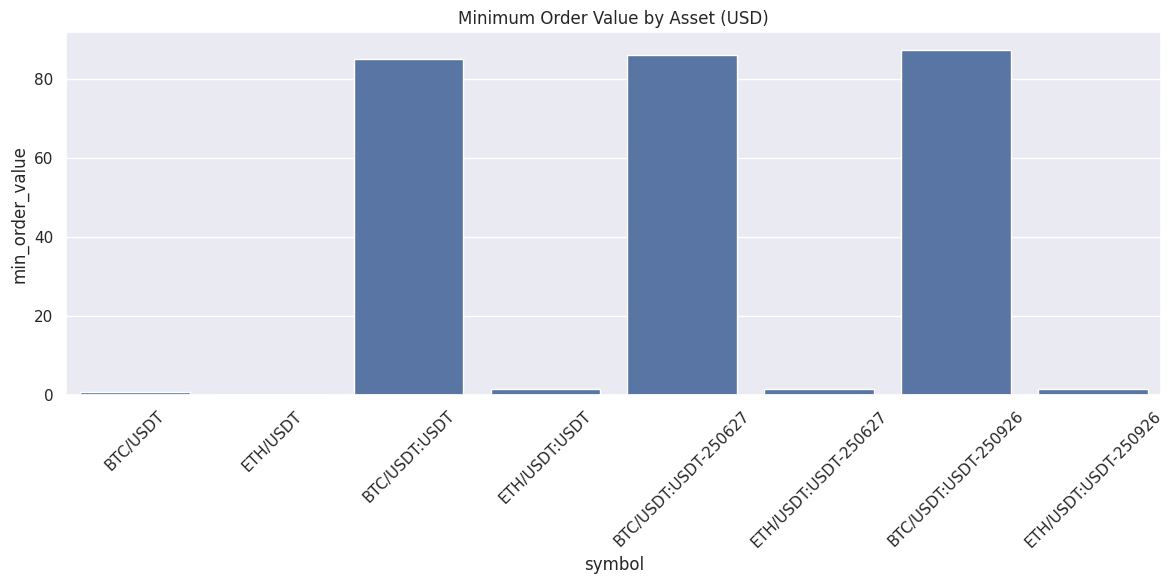

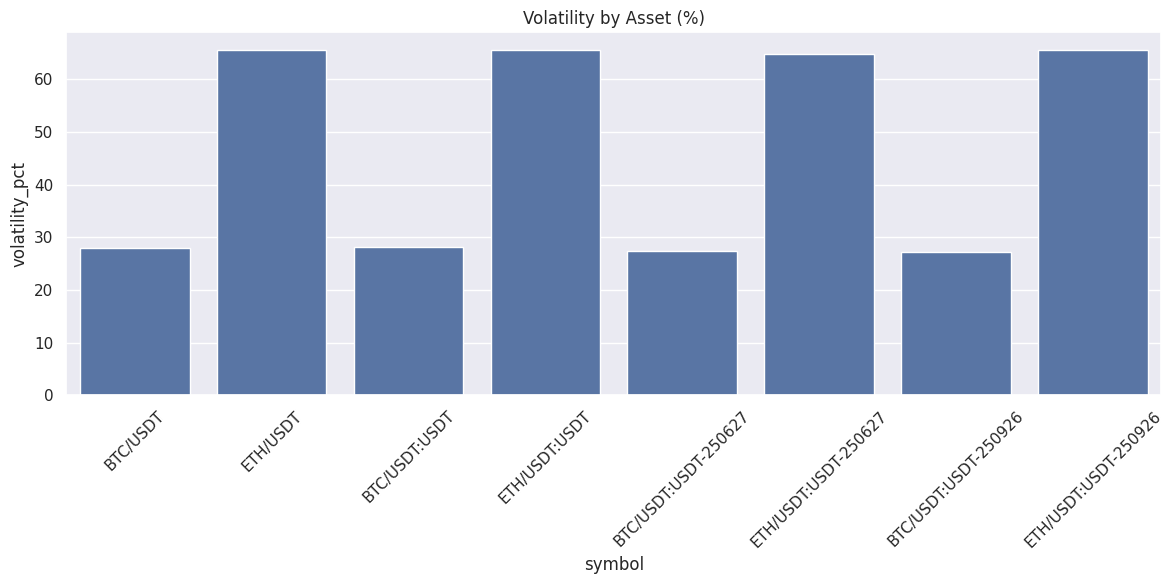

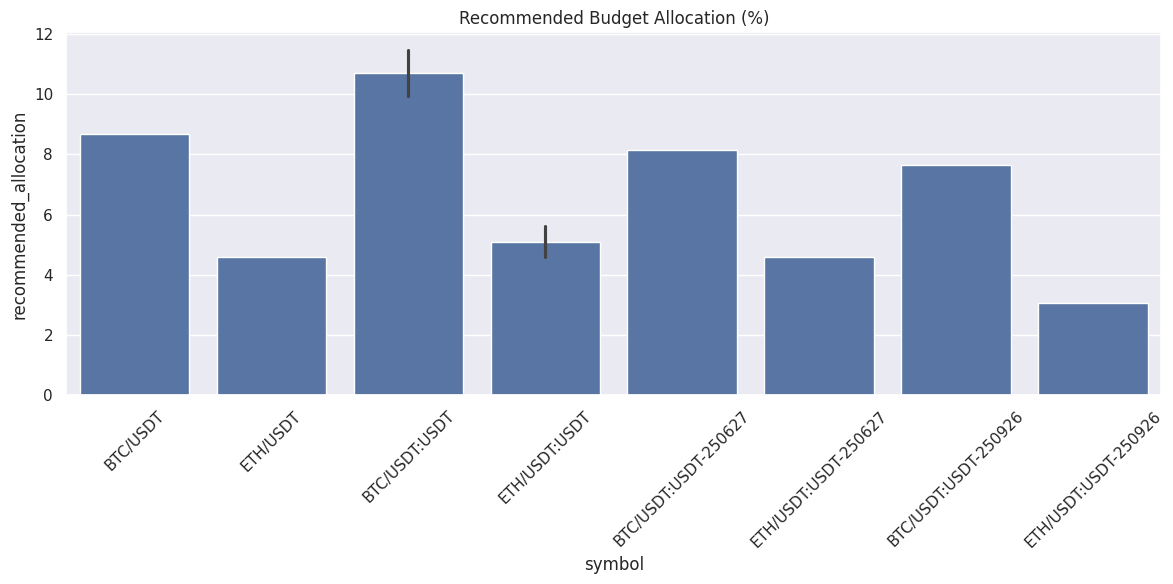

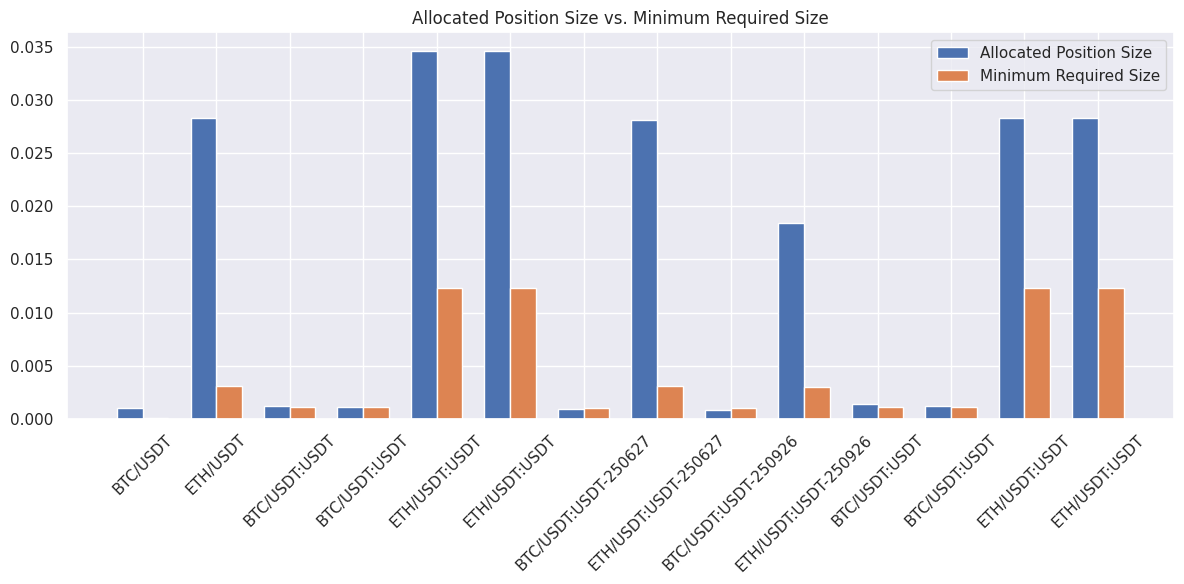

In [9]:
def plot_min_order_values(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='symbol', y='min_order_value', data=df)
    plt.title('Minimum Order Value by Asset (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_volatility(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='symbol', y='volatility_pct', data=df)
    plt.title('Volatility by Asset (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_allocations(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='symbol', y='recommended_allocation', data=df)
    plt.title('Recommended Budget Allocation (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_position_vs_min(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df))
    width = 0.35

    ax.bar(x - width/2, df['allocated_position_size'], width, label='Allocated Position Size')
    ax.bar(x + width/2, df['effective_min_size'], width, label='Minimum Required Size')

    ax.set_title('Allocated Position Size vs. Minimum Required Size')
    ax.set_xticks(x)
    ax.set_xticklabels(df['symbol'], rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_min_order_values(market_df)
plot_volatility(market_df)
plot_allocations(market_df)
plot_position_vs_min(market_df)

In [10]:
def print_recommendations(df):
    # Filter to show only assets that meet minimum requirements
    viable_assets = df[df['meets_requirements']].sort_values('recommended_allocation', ascending=False)
    
    # Print recommendations
    print("=== TRADING RECOMMENDATIONS WITH $1,000 BUDGET ===")
    print(f"\nViable assets that meet minimum requirements: {len(viable_assets)}/{len(df)}")
    print("\nRecommended Trading Allocation:")
    
    for idx, row in viable_assets.iterrows():
        print(f"\n{row['symbol']}:")
        print(f"  - Allocation: {row['recommended_allocation']:.2f}% (${row['allocated_budget']:.2f})")
        print(f"  - Position Size: {row['allocated_position_size']:.6f} {row['base']}")
        print(f"  - Current Price: ${row['price']:.2f}")
        print(f"  - Volatility: {row['volatility_pct']:.2f}%")
        print(f"  - Expected Spread: ${row['typical_spread_usd']:.2f}")
        print(f"  - Min. Required Size: {row['effective_min_size']:.6f} {row['base']}")
        
    if len(viable_assets) == 0:
        print("\nNo assets meet the minimum requirements with the current budget.")
        print("Consider increasing your budget or looking for assets with lower minimum requirements.")
    
    # Show non-viable assets and why they don't work
    non_viable = df[~df['meets_requirements']].sort_values('min_order_value')
    if len(non_viable) > 0:
        print("\n=== ASSETS THAT DON'T MEET MINIMUM REQUIREMENTS ===")
        for idx, row in non_viable.iterrows():
            additional_needed = (row['effective_min_size'] - row['allocated_position_size']) * row['price']
            print(f"\n{row['symbol']}:")
            print(f"  - Allocation: ${row['allocated_budget']:.2f} (not enough)")
            print(f"  - Min Required: {row['effective_min_size']:.6f} {row['base']} (${row['effective_min_size'] * row['price']:.2f})")
            print(f"  - Additional Budget Needed: ${additional_needed:.2f}")

# Print recommendations
print_recommendations(market_df)

=== TRADING RECOMMENDATIONS WITH $1,000 BUDGET ===

Viable assets that meet minimum requirements: 11/14

Recommended Trading Allocation:

BTC/USDT:USDT:
  - Allocation: 11.73% ($117.30)
  - Position Size: 0.001378 BTC
  - Current Price: $85104.20
  - Volatility: 28.16%
  - Expected Spread: $2396.22
  - Min. Required Size: 0.001175 BTC

BTC/USDT:USDT:
  - Allocation: 10.71% ($107.10)
  - Position Size: 0.001258 BTC
  - Current Price: $85104.30
  - Volatility: 28.16%
  - Expected Spread: $2396.23
  - Min. Required Size: 0.001175 BTC

BTC/USDT:USDT:
  - Allocation: 10.71% ($107.10)
  - Position Size: 0.001258 BTC
  - Current Price: $85104.20
  - Volatility: 28.16%
  - Expected Spread: $2396.26
  - Min. Required Size: 0.001175 BTC

BTC/USDT:
  - Allocation: 8.67% ($86.70)
  - Position Size: 0.001018 BTC
  - Current Price: $85156.70
  - Volatility: 28.05%
  - Expected Spread: $2389.03
  - Min. Required Size: 0.000059 BTC

ETH/USDT:USDT:
  - Allocation: 5.61% ($56.10)
  - Position Size: 0.03

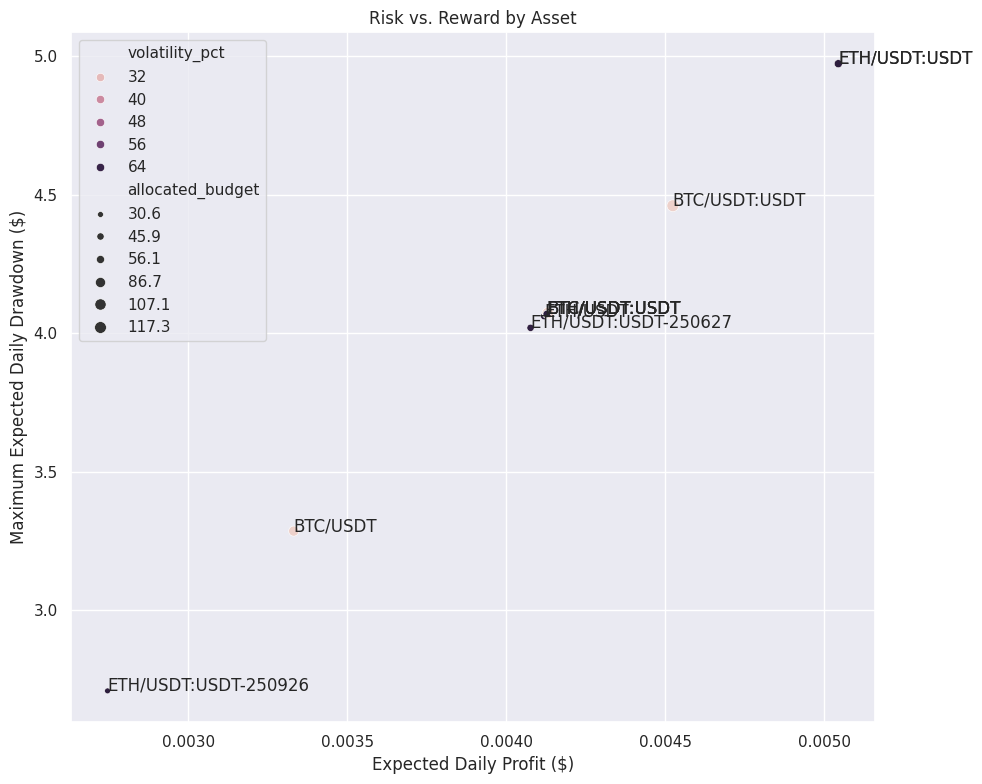

Risk-Reward Summary:
                  symbol  allocated_budget  daily_expected_pnl  \
10         BTC/USDT:USDT             117.3            0.004524   
1               ETH/USDT              45.9            0.004120   
7   ETH/USDT:USDT-250627              45.9            0.004077   
9   ETH/USDT:USDT-250926              30.6            0.002746   
11         BTC/USDT:USDT             107.1            0.004131   
0               BTC/USDT              86.7            0.003332   
2          BTC/USDT:USDT             107.1            0.004131   
4          ETH/USDT:USDT              56.1            0.005045   
5          ETH/USDT:USDT              56.1            0.005045   
12         ETH/USDT:USDT              45.9            0.004128   
13         ETH/USDT:USDT              45.9            0.004128   

    max_daily_drawdown  risk_reward_ratio  
10            4.460130         985.816616  
1             4.061247         985.816616  
7             4.019024         985.816616  
9         

In [11]:
def calculate_risk_reward(df):
    """Calculate additional risk/reward metrics"""
    # Expected daily PnL based on volatility and recommended allocation
    df['daily_expected_pnl'] = df['allocated_budget'] * df['expected_profit_pct'] / 365
    
    # Maximum expected drawdown based on volatility (99% confidence)
    df['max_daily_drawdown'] = df['allocated_budget'] * df['volatility'] * 2.58 / np.sqrt(365)
    
    # Risk-reward ratio (lower is better)
    df['risk_reward_ratio'] = df['max_daily_drawdown'] / df['daily_expected_pnl']
    
    return df

def plot_risk_reward(df):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='daily_expected_pnl', 
        y='max_daily_drawdown', 
        size='allocated_budget', 
        hue='volatility_pct',
        data=df
    )
    plt.title('Risk vs. Reward by Asset')
    plt.xlabel('Expected Daily Profit ($)')
    plt.ylabel('Maximum Expected Daily Drawdown ($)')

    # Add asset labels to the plot
    for idx, row in df.iterrows():
        plt.annotate(row['symbol'], (row['daily_expected_pnl'], row['max_daily_drawdown']))

    plt.tight_layout()
    plt.show()

# Calculate risk-reward metrics
viable_assets = market_df[market_df['meets_requirements']] if len(market_df[market_df['meets_requirements']]) > 0 else market_df
risk_df = calculate_risk_reward(viable_assets.copy())

# Plot risk vs. reward
plot_risk_reward(risk_df)

# Show summary table of risk-reward metrics
risk_summary = risk_df[['symbol', 'allocated_budget', 'daily_expected_pnl', 'max_daily_drawdown', 'risk_reward_ratio']]
print("Risk-Reward Summary:")
print(risk_summary.sort_values('risk_reward_ratio'))

=== OPTIMAL ALLOCATION STRATEGY ===

Total budget: $1000.00
Assets in portfolio: 3

BTC/USDT:
  - Budget: $301.67 (30.17%)
  - Position: 0.003542 BTC
  - Current Price: $85156.70
  - Volatility: 28.05%
ETH/USDT:
  - Budget: $301.67 (30.17%)
  - Position: 0.186098 ETH
  - Current Price: $1621.01
  - Volatility: 65.52%
BTC/USDT:USDT:
  - Budget: $396.67 (39.67%)
  - Position: 0.004661 BTC
  - Current Price: $85104.30
  - Volatility: 28.16%


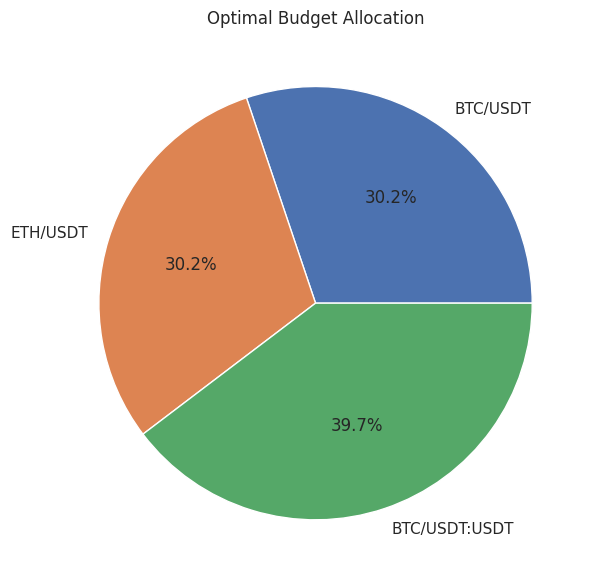

In [13]:
def optimize_allocation(df, budget=TOTAL_BUDGET, max_assets=3):
    """Find optimal allocation based on minimum requirements and risk-reward"""
    # Ensure we're working with a copy
    df = df.copy()
    
    # Add profit_to_drawdown ratio to the main dataframe first
    df['profit_to_drawdown'] = df['expected_profit_pct'] / df['volatility']
    
    # Filter out assets where the minimum order size is greater than what we can afford
    affordable = df[df['effective_min_size'] * df['price'] <= budget]
    
    if affordable.empty:
        print("No affordable assets found.")
        return pd.DataFrame()
    
    # Sort by expected profit to max drawdown ratio (higher is better)
    affordable = affordable.sort_values('profit_to_drawdown', ascending=False)
    
    # Take top max_assets with best risk-reward
    top_assets = affordable.head(max_assets)
    
    # Ensure minimum allocation meets requirements
    remaining_budget = budget
    allocations = {}
    
    # First pass: allocate minimum requirements
    for idx, row in top_assets.iterrows():
        min_cost = row['effective_min_size'] * row['price']
        allocations[row['symbol']] = min_cost
        remaining_budget -= min_cost
    
    # Check if we can afford all minimums
    if remaining_budget < 0:
        print("Cannot meet minimum requirements for all selected assets.")
        # Try with fewer assets
        return optimize_allocation(df, budget, max_assets-1)
    
    # Second pass: allocate remaining budget proportionally to profit_to_drawdown ratio
    if remaining_budget > 0:
        total_score = top_assets['profit_to_drawdown'].sum()
        for idx, row in top_assets.iterrows():
            proportion = row['profit_to_drawdown'] / total_score
            additional = remaining_budget * proportion
            allocations[row['symbol']] += additional
    
    # Create results DataFrame
    results = []
    for symbol, amount in allocations.items():
        asset_row = df[df['symbol'] == symbol].iloc[0]
        position_size = amount / asset_row['price']
        
        results.append({
            'symbol': symbol,
            'base': asset_row['base'],
            'price': asset_row['price'],
            'volatility_pct': asset_row['volatility_pct'],
            'budget_allocation': amount,
            'allocation_pct': (amount / budget) * 100,
            'position_size': position_size,
            'min_required_size': asset_row['effective_min_size'],
            'profit_to_drawdown': asset_row['profit_to_drawdown']
        })
    
    return pd.DataFrame(results)

def plot_optimal_allocation(df):
    plt.figure(figsize=(10, 6))
    plt.pie(
        df['budget_allocation'], 
        labels=df['symbol'],
        autopct='%1.1f%%'
    )
    plt.title('Optimal Budget Allocation')
    plt.tight_layout()
    plt.show()

# Calculate optimal allocation
optimal_allocation = optimize_allocation(market_df)

# Display results
if not optimal_allocation.empty:
    print("=== OPTIMAL ALLOCATION STRATEGY ===")
    print(f"\nTotal budget: ${TOTAL_BUDGET:.2f}")
    print(f"Assets in portfolio: {len(optimal_allocation)}\n")
    
    for idx, row in optimal_allocation.iterrows():
        print(f"{row['symbol']}:")
        print(f"  - Budget: ${row['budget_allocation']:.2f} ({row['allocation_pct']:.2f}%)")
        print(f"  - Position: {row['position_size']:.6f} {row['base']}")
        print(f"  - Current Price: ${row['price']:.2f}")
        print(f"  - Volatility: {row['volatility_pct']:.2f}%")
    
    # Plot optimal allocation
    plot_optimal_allocation(optimal_allocation)
else:
    print("Could not determine optimal allocation with the current budget constraints.")

In [14]:
def save_results(market_df, optimal_allocation, filename='crypto_scanner_results.csv'):
    """Save the scanner results to a CSV file"""
    # Save market data with metrics
    market_df.to_csv('crypto_market_data.csv', index=False)
    
    # Save optimal allocation if available
    if not optimal_allocation.empty:
        optimal_allocation.to_csv('optimal_allocation.csv', index=False)
    
    # Create a summary report
    with open('scanner_summary.txt', 'w') as f:
        f.write(f"Cryptocurrency Scanner Report\n")
        f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"Total budget: ${TOTAL_BUDGET:.2f}\n")
        f.write(f"Total assets analyzed: {len(market_df)}\n")
        f.write(f"Viable assets: {len(market_df[market_df['meets_requirements']])}\n\n")
        
        f.write("Recommended allocations:\n")
        for symbol, group in market_df[market_df['meets_requirements']].groupby('symbol'):
            row = group.iloc[0]
            f.write(f"- {symbol}: ${row['allocated_budget']:.2f} ({row['allocated_position_size']:.6f} {row['base']})\n")
    
    print(f"Results saved to disk: crypto_market_data.csv, optimal_allocation.csv, scanner_summary.txt")

# Save results
save_results(market_df, optimal_allocation)

Results saved to disk: crypto_market_data.csv, optimal_allocation.csv, scanner_summary.txt


In [15]:
def main():
    print("Cryptocurrency Scanner for Thalex SimpleQuoter")
    print(f"Total budget: ${TOTAL_BUDGET}")
    print("Analyzing which cryptocurrencies you can trade with your budget...")
    print()
    
    # Connect to exchange
    exchange = connect_to_exchange('binance')
    
    # Fetch market data
    market_df = fetch_market_data()
    
    # Calculate volatility
    volatility_data = []
    for _, row in market_df.iterrows():
        symbol = row['symbol']
        historical_df = fetch_historical_data(symbol)
        volatility = calculate_volatility(historical_df)
        volatility_data.append({
            'symbol': symbol,
            'volatility': volatility,
            'volatility_pct': volatility * 100
        })
    volatility_df = pd.DataFrame(volatility_data)
    market_df = market_df.merge(volatility_df, on='symbol')
    
    # Calculate trading metrics
    market_df = calculate_trading_metrics(market_df)
    
    # Generate recommendations
    print_recommendations(market_df)
    
    # Calculate optimal allocation
    optimal_allocation = optimize_allocation(market_df)
    
    # Save results
    save_results(market_df, optimal_allocation)
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

Cryptocurrency Scanner for Thalex SimpleQuoter
Total budget: $1000
Analyzing which cryptocurrencies you can trade with your budget...

Successfully connected to Binance
=== TRADING RECOMMENDATIONS WITH $1,000 BUDGET ===

Viable assets that meet minimum requirements: 12/14

Recommended Trading Allocation:

BTC/USDT:USDT:
  - Allocation: 10.71% ($107.10)
  - Position Size: 0.001256 BTC
  - Current Price: $85249.80
  - Volatility: 27.82%
  - Expected Spread: $2371.52
  - Min. Required Size: 0.001173 BTC

BTC/USDT:USDT:
  - Allocation: 10.71% ($107.10)
  - Position Size: 0.001256 BTC
  - Current Price: $85249.80
  - Volatility: 27.82%
  - Expected Spread: $2371.52
  - Min. Required Size: 0.001173 BTC

BTC/USDT:USDT:
  - Allocation: 10.71% ($107.10)
  - Position Size: 0.001256 BTC
  - Current Price: $85249.80
  - Volatility: 27.82%
  - Expected Spread: $2371.52
  - Min. Required Size: 0.001173 BTC

BTC/USDT:USDT:
  - Allocation: 10.71% ($107.10)
  - Position Size: 0.001256 BTC
  - Current P